In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
import weather
import utils
import constants
from utils import *
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from matplotlib import cm

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dates=weather.get_dates(DBNAME)
dates=[str(x[0]) for x in dates]
dates

['20170624',
 '20170625',
 '20170626',
 '20170627',
 '20170628',
 '20170629',
 '20170630',
 '20170701',
 '20170702',
 '20170703',
 '20170704',
 '20170705',
 '20170706',
 '20170707',
 '20170708']

In [4]:
w=weather.getdf_date(DBNAME,'20170701')
w['Hour']=w.apply(lambda x:int(x['Time'][:2]),axis=1)
w=w.drop(['Point','Time','Location'],axis=1)
w.head()

,X,Y,Forecast,Hour
0,19,0,FN,0
1,7,2,FN,0
2,18,3,FN,0
3,2,4,FN,0
4,15,4,FN,0


In [5]:
w.query('X>=19 and X<=21 and Y>=4 and Y<=6 and Hour==9')['Forecast'].tolist()[0]

u'PC'

In [12]:
def process_date(date):
    if weekday(date)==0:
        return None
    df=taxis.getdf_loc_date(DBNAME,date,LAT,LON)
    h=df.quantile(q=0.9)['TaxiCount']
    l=df.quantile(q=0.1)['TaxiCount']
    df['Date']=date
    df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
    df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
    df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
    df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
    df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)
    df=df.query('(TaxiCount>=@l and TaxiCount<=@h) and Weekday==1')[['Hour','Minute','PeakHour','TaxiCount']]
    def get_weather(r):
        x,y=utils.get_grid_cell(LAT,LON)
        h=r['Hour']
        f=w.query('X>=@x-1 and X<=@x+1 and Y>=@y-1 and Y<=@y+1 and Hour==@h')['Forecast'].tolist()[0] 
        return constants.WEATHER_CODES[f]
    df['Forecast']=df.apply(get_weather,axis=1)
    return df

In [13]:
data=[process_date(date) for date in dates]
data=[x for x in data if x is not None]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
             Hour      Minute    PeakHour   TaxiCount    Forecast
count  235.000000  235.000000  235.000000  235.000000  235.000000
mean    11.527660   27.468085    0.327660   30.221277   15.991489
std      6.873264   17.049264    0.470362   10.720317    2.373269
min      0.000000    0.000000    0.000000   12.000000    5.000000
25%      5.000000   15.000000    0.000000   21.000000   16.000000
50%     13.000000   30.000000    0.000000   30.000000   16.000000
75%     17.500000   40.000000    1.000000   40.000000   17.000000
max     23.000000   55.000000    1.000000   48.000000   17.000000


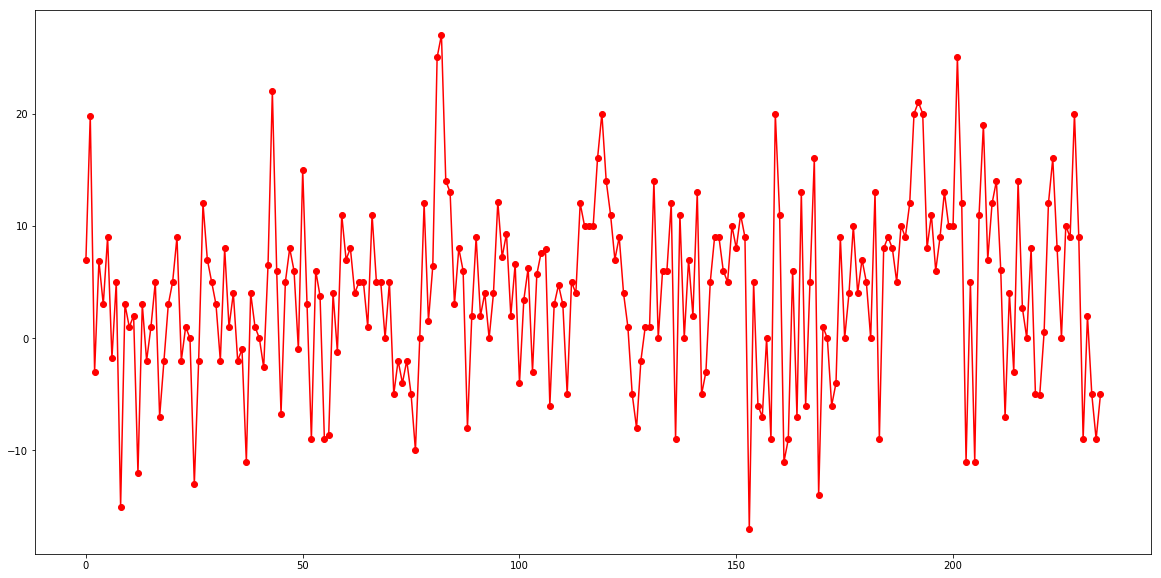

In [14]:
kn=KNeighborsRegressor(weights='distance')
for df in data[:-1]:
    X=df.drop(['TaxiCount'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    kn.fit(X,y)
    print kn.score(X,y)
    
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=kn.predict(Xt)
e=[x-y for x,y in zip(P,yt)]


#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-ro')
plt.show()

/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.858005213337
0.938982316371
0.945083490777
0.948347294766
0.962207948639
0.941098275678
0.93072342325
0.930621740612
0.948879066185
             Hour      Minute    PeakHour   TaxiCount    Forecast
count  235.000000  235.000000  235.000000  235.000000  235.000000
mean    11.527660   27.468085    0.327660   30.221277   15.991489
std      6.873264   17.049264    0.470362   10.720317    2.373269
min      0.000000    0.000000    0.000000   12.000000    5.000000
25%      5.000000   15.000000    0.000000   21.000000   16.000000
50%     13.000000   30.000000    0.000000   30.000000   16.000000
75%     17.500000   40.000000    1.000000   40.000000   17.000000
max     23.000000   55.000000    1.000000   48.000000   17.000000


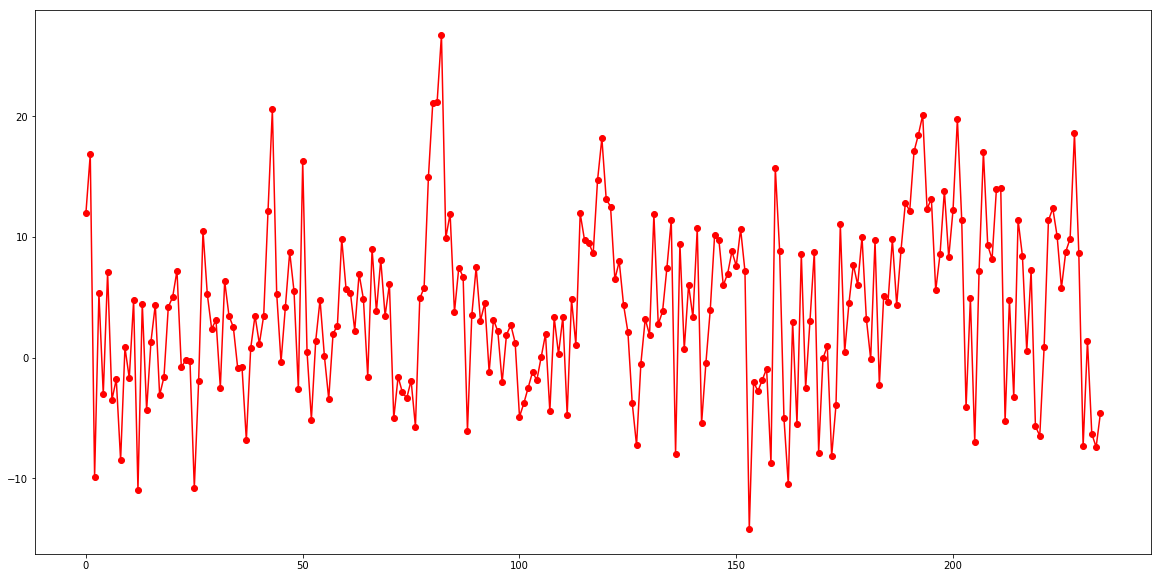

In [15]:
rf=RandomForestRegressor(n_estimators=10,n_jobs=10)
for df in data[:-1]:
    X=df.drop(['TaxiCount'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    rf.fit(X,y)
    rf.n_estimators+=10
    print rf.score(X,y)
    
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]


#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-ro')
plt.show()

/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.849786286141
0.928572335098
0.950341172087
0.949491482228
0.959161806519
0.943892735494
0.932549344729
0.929412319902
0.952529943389
             Hour      Minute    PeakHour   TaxiCount    Forecast
count  235.000000  235.000000  235.000000  235.000000  235.000000
mean    11.527660   27.468085    0.327660   30.221277   15.991489
std      6.873264   17.049264    0.470362   10.720317    2.373269
min      0.000000    0.000000    0.000000   12.000000    5.000000
25%      5.000000   15.000000    0.000000   21.000000   16.000000
50%     13.000000   30.000000    0.000000   30.000000   16.000000
75%     17.500000   40.000000    1.000000   40.000000   17.000000
max     23.000000   55.000000    1.000000   48.000000   17.000000


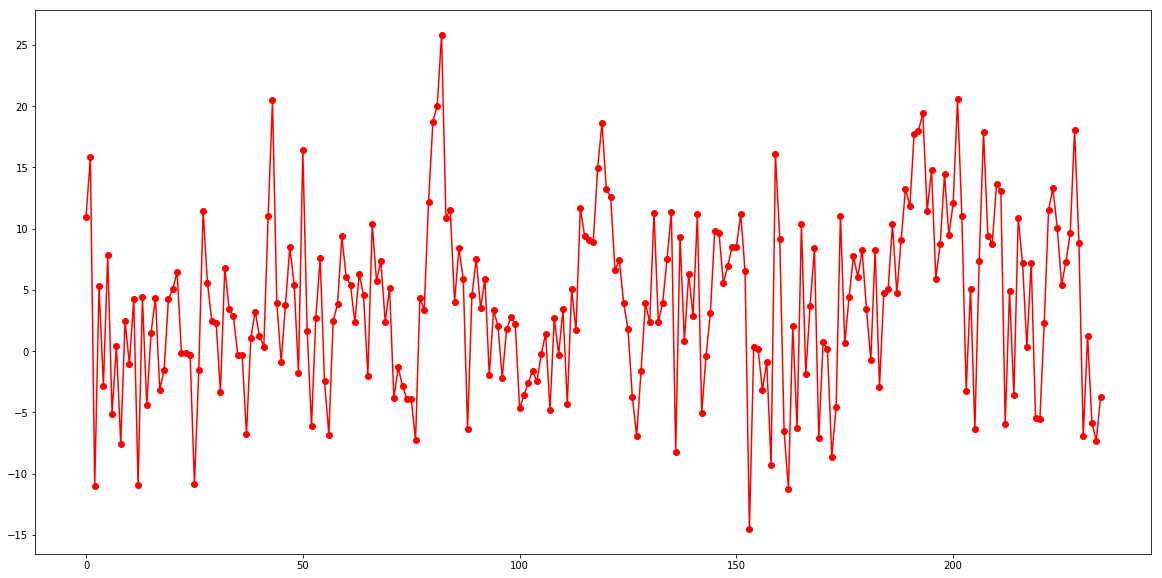

In [16]:
rf=RandomForestRegressor(n_estimators=10,n_jobs=10,criterion='mae')
for df in data[:-1]:
    X=df.drop(['TaxiCount'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    rf.fit(X,y)
    rf.n_estimators+=10
    print rf.score(X,y)
    
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]


#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-ro')
plt.show()